<left><img width=25% src="img/cornell_tech2.svg"></left>

# Lecture 6: Generative Classifiers

### Applied Machine Learning

__Volodymyr Kuleshov__, lecture given by __Brandon Amos__<br>Cornell Tech

# Announcements

* Assignment 1 is due tonight
* Assignment 2 will be released Monday 9/23
* Project proposals will be due on Monday 9/23

# Part 1: Generative Classifiers

In this lecture, we are going to look at generative classifiers and their applications.

# The Iris Flowers Dataset

We will continue using the Iris dataset for classification ([R. A. Fisher, 1936](https://en.wikipedia.org/wiki/Ronald_Fisher)).

The task is to classify subspecies of Iris flowers based on their measurements:

In [79]:
import numpy as np; np.set_printoptions(precision=2)
import pandas as pd; pd.options.display.float_format = "{:,.2f}".format
import warnings; warnings.filterwarnings('ignore')
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).sample(5, random_state=0)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
114,5.80,2.80,5.10,2.40,2
62,6.00,2.20,4.00,1.00,1
33,5.50,4.20,1.40,0.20,0
107,7.30,2.90,6.30,1.80,2
7,5.00,3.40,1.50,0.20,0


If we only consider the first two feature columns, we can visualize the dataset in 2D.

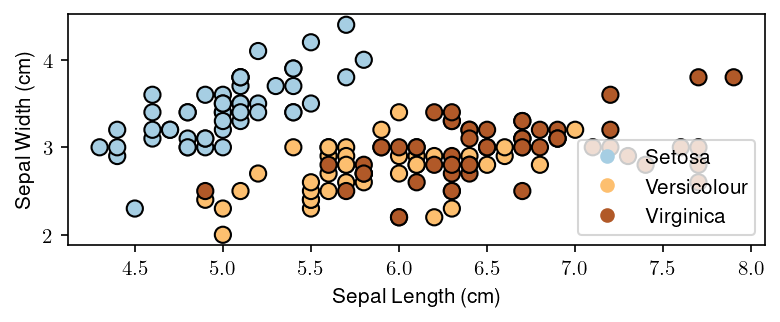

In [80]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
import matplotlib.pyplot as plt
plt.rcParams.update({ "figure.figsize": [6, 2], "figure.dpi": 150, "text.usetex": True, "font.family": "Helvetica"})

# create 2d version of dataset
X = iris_X.to_numpy()[:,:2]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Plot also the training points
p1 = plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length (cm)'); plt.ylabel('Sepal Width (cm)')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica'], loc='lower right');

# Review: Supervised Learning Models

A supervised learning model can be seen as directly predicting a one-hot embedding of the target class:

$$
\underbrace{\left[ 
\begin{array}{c}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\end{array}
\right]}_\text{input}
{\to}\text{model $f_\theta(x)$}{\to}
\underbrace{\left[ 
\begin{array}{c}
0 \\
1 \\
0 \\
\end{array}
\right]}_\text{output}
$$

In this example, the $f_\theta(x)$ predicts the second class for input $x$.

# Review: Probabilistic Models

A probabilistic model outputs a vector of class probabilities

$$
\underbrace{\left[ 
\begin{array}{c}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\end{array}
\right]}_\text{input}
{\to}\text{model $P_\theta(y|x)$}{\to}
\underbrace{\left[ 
\begin{array}{c}
0.1 \\
0.7 \\
0.2 \\
\end{array}
\right]}_\text{output}
$$

Here, the $P_\theta(y|x)$ still predicts the second class for input $x$.

# Example: A logistic (softmax) model
This model outputs a probability distribution 

$$
P_\theta(y| x) 
= \left[ \begin{array}{c}
P_\theta(y=0| x) \\
P_\theta(y=1| x) \\
\end{array} \right]
= \left[ \begin{array}{c}
1-\sigma(\theta^\top x) \\
\sigma(\theta^\top x) \\
\end{array} \right]
$$

where $\theta^\top x$ is a linear model and
$$\sigma(z) = \frac{1}{1 + \exp(-z)}$$
is the *sigmoid* or *logistic* function.

Let's train logistic/softmax regression on this dataset.

In [81]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)

# Create an instance of Logistic Regression Classifier and fit the data.
X = iris_X.to_numpy()[:,:2]
Y = iris_y.copy()
logreg.fit(X, Y);

We visualize the regions predicted to be associated with the blue, brown, and yellow classes and the lines between them are the decision boundaries.

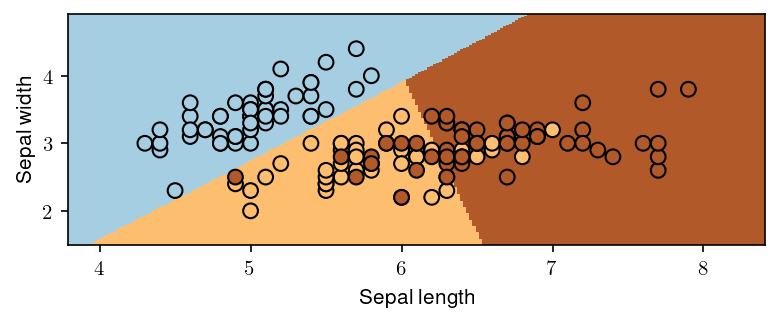

In [82]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z_lr = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z_lr = Z_lr.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z_lr, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired, s=50)
plt.xlabel('Sepal length'); plt.ylabel('Sepal width');

# Discriminative vs. Generative Models

Logistic regression is an example of a *discriminative* classifier.
$$
P_\theta(y| x) 
= \left[ \begin{array}{c}
P_\theta(y=0| x) \\
P_\theta(y=1| x) \\
\end{array} \right]
$$
* It directly transforms $x$ into a score for each class $y$, e.g., via the formula $\sigma(\theta^\top x)$
* It can be interpreted as defining a *conditional* probability $P_\theta(y|x)$

Generative classifiers instead define distributions $P_\theta(x|y)$ and $P_\theta(y)$ over $x,y$.

# Relation to text-to-image (TTI) models

+ TTI models can also be written as $P(x|y)$, where $x$ is an image (millions of dimensions) and $y$ is a text description of it (many possibilities).
+ **This lecture:** $x$ is a flower representation (4D), $y$ is a class (3 choices)

<img width='100%' src="img/tti.png"/>
(<a href="https://www.marktechpost.com/2022/11/14/how-do-dall%C2%B7e-2-stable-diffusion-and-midjourney-work/">Image source</a>)

# Generative Classifiers: Intuition

Imagine we have a dataset (e.g., flowers). We can fit a Gaussian to each class:

<center><img width=40% src="img/gda_example.png"></center>

At test time, we predict the class of the Gaussian that is most likely to have generated the data.

Given a new flower $x'$, we would compare the probabilities of three models:

\begin{align*}
P_\theta(x'|y=\text{0})P_\theta(y=\text{0}) \\ P_\theta(x'|y=\text{1})P_\theta(y=\text{1}) \\ P_\theta(x'|y=\text{2})P_\theta(y=\text{2})
\end{align*}

We output the class that's more likely to have generated $x'$.

<center><img width=40% src="img/gda_example.png"></center>

# Generative Classifiers: Details

Another approach to classification is to use *generative* models.

* A generative approach first builds a model of $x$ for each class:
$$ P_\theta(x | y=k) \; \text{for each class $k$}.$$
$P_\theta(x | y=k)$ *scores* each $x$ according to how well it matches class $k$.

* A class probability $P_\theta(y=k)$ encoding our prior beliefs.
These are often just the % of each class in the data.

In the context of flower classification (e.g., Setosa vs. non-Setosa), we would fit two models on a corpus of emails $x$ with spam/non-spam labels $y$:

\begin{align*}
P_\theta(x|y=\text{0}) && \text{and} && P_\theta(x|y=\text{1})
\end{align*}

* $P_\theta(x | y=1)$ *scores* each $x$ based on how much it looks like Iris Setosa.
* $P_\theta(x | y=0)$ *scores* each $x$ based on whether it looks like non-Setosa.

We also choose a prior $P(y)$.

Given a new $x'$, we would compare the probabilities of both models:

\begin{align*}
P_\theta(x'|y=\text{0})P_\theta(y=\text{0}) && \text{vs.} && P_\theta(x'|y=\text{1})P_\theta(y=\text{1})
\end{align*}

We output the class that's more likely to have generated $x'$.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 2: Gaussian Mixture Models

Next, we will define another generative model: Gaussian mixtures.

# A Generative Classifier for Iris Flowers

To define a generative classifier for Iris flowers, we need to define three probabilities:

\begin{align*}
P_\theta(x|y=\text{0}) && P_\theta(x|y=\text{1}) && P_\theta(x|y=\text{2})
\end{align*}

We also define priors $P_\theta(y=\text{0}), P_\theta(y=\text{1}), P_\theta(y=\text{2})$.

How do we choose $P_\theta(x|y=k)$ and $P_\theta(y)$?

# Review: Normal (Gaussian) Distribution

A [multivariate normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distribution with parameters $\theta = (\mu, \Sigma)$
is a probability over a $d$-dimensional $x \in \mathbb{R}^d$

$$
P_\theta(x; \mu, \Sigma) = \frac{1}{\sqrt{(2 \pi)^d | \Sigma |}} \exp\left(-\frac{1}{2} (x - \mu)^\top \Sigma^{-1} (x-\mu) \right)
$$

In one dimension, this reduces to $\frac{1}{\sqrt{2 \pi}\sigma} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2} \right)$.

This is what the density of a Normal distribution looks like in 2D:

<center><img width=70% src="img/multivariate_gaussian1.png"></center>

This is how we can visualize it in a 2D plane:

<center><img width=50% src="img/multivariate_gaussian2.png"></center>

# Gaussian Mixture Model

A *Gaussian mixture* model (GMM) $P_\theta(x,y)$ is defined for *real-valued data* $x \in \mathbb{R}^d$.

The $\theta$ contains prior parameters $\vec\phi = (\phi_1,...,\phi_K)$ and $K$ sets of per-class Gaussian parameters $\mu_k, \Sigma_k$.

The probability of the data $x$ for each class is a multivariate Gaussian
$$P_\theta(x|y=k) = \mathcal{N}(x ; \mu_k, \Sigma_k).$$

The probability over $y$ is Categorical:
$P_\theta(y=k) = \phi_k$.

# Gaussian Mixture Model: Intuition

Fitting a GMM model amounts to fitting one Gaussian per class.

<center><img width=40% src="img/gda_example.png"></center>

At test time, we predict the class of the Gaussian that is most likely to have generated the data.

Mixtures can express distributions that a single mixture component can't:

<center><img width=65% src="img/mogdensity1d_v2.png"></center>

Here, we have a mixture of 3 Gaussians.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 3: Gaussian Discriminant Analysis

Next, we will use GMMs as the basis for a new generative classification algorithm, Gaussian Discriminant Analysis (GDA).

# The Parameters of a GMM

We need to learn the parameters of two sets of distributions:
* The distribution over classes is [Categorical](https://en.wikipedia.org/wiki/Categorical_distribution), denoted $\text{Categorical}(\phi_1, \phi_2, ..., \phi_K)$. Thus, $P_\theta(y=k) = \phi_k$.
* The conditional probability $P(x\mid y=k)$ of the data under class $k$ is a [multivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) $\mathcal{N}(x; \mu_k, \Sigma_k)$ with mean and covariance $\mu_k, \Sigma_k$.

# Learning the Parameters $\mu_k, \Sigma_k$

* Consider the dataset of all the points $x$ for which $y=k$.
* Goal: learn the mean and variance $\theta_k=(\mu_k, \Sigma_k)$ of a Normal that generates $x$
* What is the maximum likelihood $\mu_k, \Sigma_k$ in this case? The formulation is:

$$\arg\max_{\theta_k} P_{\theta_k}(x|y=k)$$

* For Gaussians, these are the empirical means and covariances of each class.
\begin{align*}
\mu_k & = \frac{\sum_{i: y^{(i)} = k} x^{(i)}}{n_k} \\
\Sigma_k & = \frac{\sum_{i: y^{(i)} = k} (x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^\top}{n_k} \\
\end{align*}

# Learning the Parameters $\phi$

Next, consider learning $\vec \phi = (\phi_1, \phi_2, \ldots, \phi_K)$. 
* We have $n$ datapoints. Each point has a label $k\in\{1,2,...,K\}$.
* Our model is a categorical and assigns a probability $\phi_k$ to each outcome $k\in\{1,2,...,K\}$.
* We want to infer $\phi_k$ assuming our dataset is sampled from the model.

What are the maximum likelihood $\phi_k$ that are most likely to have generated our data?

Intuitively, the maximum likelihood class probabilities $\phi$ should just be the class proportions that we see in the data. 
$$ \phi_k = \frac{n_k}{n}$$
for each $k$, where $n_k = |\{i : y^{(i)} = k\}|$ is the number of training targets with class $k$.

Thus, the optimal $\phi_k$ is just the proportion of data points with class $k$ in the training set!

# Querying the Model

How do we ask the model for predictions? As discussed earlier, we can apply Bayes' rule:
$$\arg\max_y P_\theta(y|x) = \arg\max_y P_\theta(x|y)P(y).$$
Thus, we can estimate the probability of $x$ and under each $P_\theta(x|y=k)P(y=k)$ and choose the class that explains the data best.

<h1 style='font-size: 1.8em'>Algorithm: Gaussian Discriminant Analysis (GDA)</h1>

* __Type__: Supervised learning (multi-class classification)
* __Model family__: Mixtures of Gaussians.
* __Objective function__: Log-likelihood.
* __Optimizer__: Closed form solution.

# Example: Iris Flower Classification

Let's see how this approach can be used in practice on the Iris dataset.
* We will learn the maximum likelihood GDA parameters
* We will compare the outputs to the true predictions.

Let's first start by computing the true parameters on our dataset.

In [83]:
# we can implement these formulas over the Iris dataset
d = 2 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X_k.T)
    phis[k] = X_k.shape[0] / float(n)

We can look at the learned parameter values and compare them to the data

In [97]:
print('mus:', mus, '\nphis:', phis)

mus: [[5.01 3.43]
 [5.94 2.77]
 [6.59 2.97]] 
phis: [0.33 0.33 0.33]


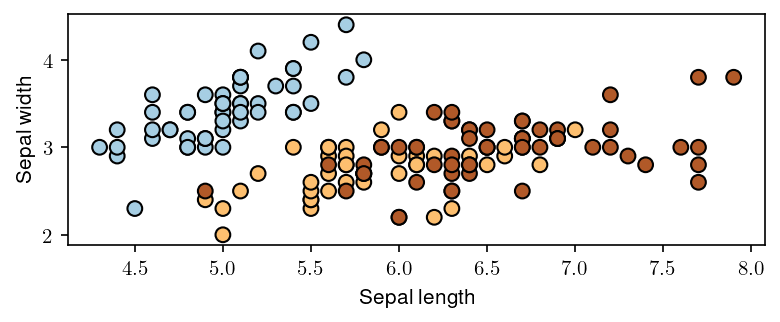

In [86]:
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired, s=50);
plt.xlabel('Sepal length'); plt.ylabel('Sepal width');

We can compute predictions using Bayes' rule.

In [87]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)
print(idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 2 2
 2 1]


We visualize the decision boundaries like we did earlier.

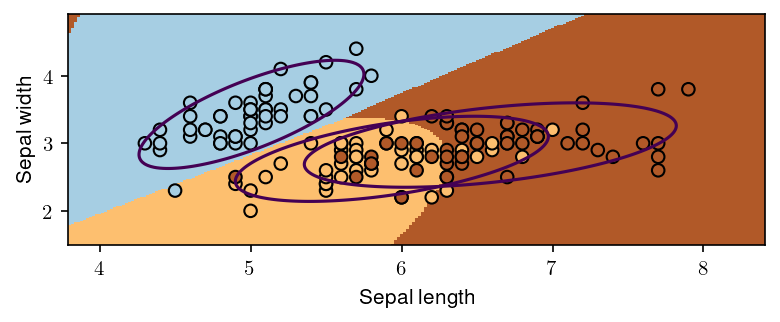

In [88]:
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K): contours[k] = logpy[k].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
for k in range(K): plt.contour(xx, yy, contours[k], levels=np.logspace(0, 1, 1))

plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length'); plt.ylabel('Sepal width');

# Special Cases of GDA

Many important generative algorithms are special cases of GDA:
* **Linear discriminant analysis (LDA):** all the covariance matrices $\Sigma_k$ take the same value.
* **Gaussian Naive Bayes:** all the covariance matrices $\Sigma_k$ are diagonal.
* **Quadratic discriminant analysis (QDA):** another term for GDA (because the decision boundary is quadratic).

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 4: Discriminative vs. Generative Classifiers

We conclude our lecture on generative classifiers by revisiting the question of how they compare to discriminative classifiers.

# Linear Discriminant Analysis

When the covariances $\Sigma_k$ in GDA are equal, we have an algorithm called Linear Discriminant Analysis or LDA.

The probability of the data $x$ for each class is a multivariate Gaussian with the same covariance $\Sigma$.
$$P_\theta(x|y=k) = \mathcal{N}(x ; \mu_k, \Sigma).$$

The probability over $y$ is Categorical:
$P_\theta(y=k) = \phi_k$.

Let's try this algorithm on the Iris flower dataset.

We compute the model parameters similarly to how we did for GDA.

In [89]:
# we can implement these formulas over the Iris dataset
d = 2 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X.T) # this is now X.T instead of X_k.T
    phis[k] = X_k.shape[0] / float(n)

# print out the means
print(mus)

[[5.01 3.43]
 [5.94 2.77]
 [6.59 2.97]]


We can compute predictions using Bayes' rule.

In [90]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)
print(idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 1 2 2
 1 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


We visualize predictions like we did earlier.

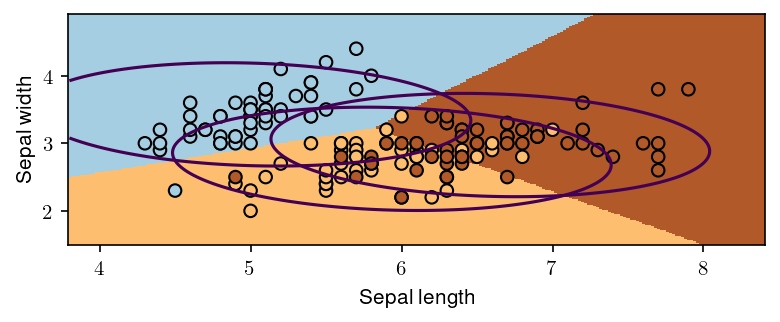

In [91]:
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K):
    contours[k] = logpy[k].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
for k in range(K):
    plt.contour(xx, yy, contours[k], levels=np.logspace(0, 1, 1))

plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length'); plt.ylabel('Sepal width');

Linear Discriminant Analysis outputs decision boundaries that are linear, just like Logistic/Softmax Regression.

Softmax or Logistic regression also produce linear boundaries. In fact, both types of algorithms make use of the same model class.

Are the algorithms equivalent?

# What Is the LDA Model Class?

We can derive a formula for $P_\theta(y|x)$ in a Bernoulli Naive Bayes or LDA model when $K=2$:
$$ P_\theta(y|x) = \frac{P_\theta(x|y)P_\theta(y)}{\sum_{y'\in \mathcal{Y}}P_\theta(x|y')P_\theta(y')} = \frac{1}{1+\exp(-\gamma^\top x)} $$
for some set of parameters $\gamma$ (whose expression can be derived from $\theta$). 

This is the same form as Logistic Regression! Does it mean that the two sets of algorithms are equivalent? 

No! They assume the same model class $\mathcal{M}$, they use a different objective $J$ to select a model in $\mathcal{M}$.

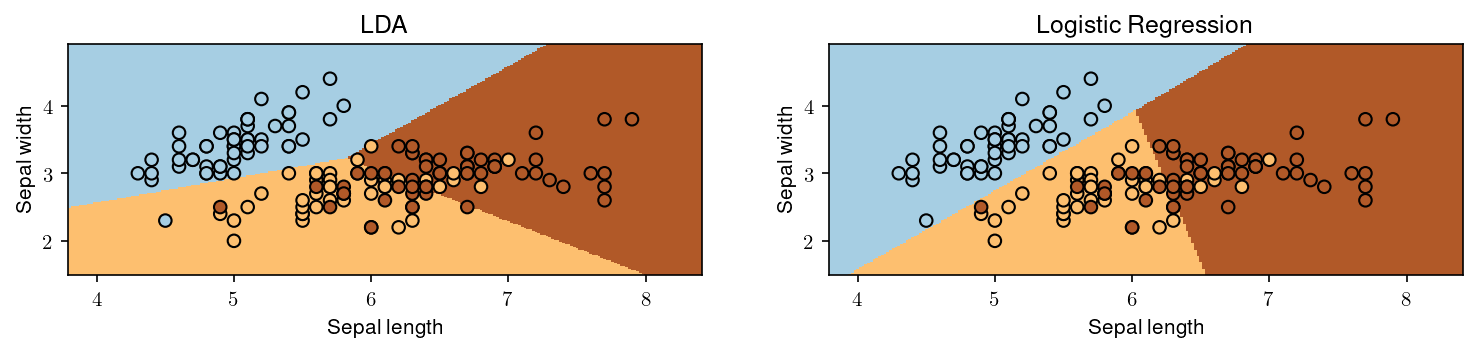

In [92]:
nrow, ncol = 1, 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6*ncol, 2*nrow))
axs[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired); axs[0].set_title('LDA')
axs[1].pcolormesh(xx, yy, Z_lr, cmap=plt.cm.Paired); axs[1].set_title('Logistic Regression')

for ax in axs:
    ax.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel('Sepal length'); ax.set_ylabel('Sepal width')

# LDA vs. Logistic Regression

What are the differences between LDA/NB and logistic regression?

* Bernoulli Naive Bayes or LDA assumes a logistic form for $P(y|x)$. But the converse is not true: logistic regression does not assume a NB or LDA model for $P(x,y)$.
* Generative models make stronger modeling assumptions. If these assumptions hold true, the generative models will perform better.
* But if they don't, logistic regression will be more robust to outliers and model misspecification, and achieve higher accuracy.

# Discriminative Approaches

Discriminative algorithms are deservingly very popular.
* Most state-of-the-art algorithms for classification are discriminative (including neural nets, boosting, SVMs, etc.)
* They are often more accurate because they make fewer modeling assumptions.

# Other Useful Features of Generative Models

Generative models can also do things that discriminative models can't do.
* __Generation__: we can sample $x \sim p(x|y)$ to generate new data (images, audio).
* __Missing value imputation__: if $x_j$ is missing, we infer it using $p(x|y)$.
* __Outlier detection__: we may detect via $p(x')$ if $x'$ is an outlier.
* __Scalability__: Simple formulas for maximum likelihood parameters.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 5 (Bonus): Maximum Likelihood Learning and GDA

Here, we look at the formal reason for how to derive the learning algorithm for GDA.

# Review: Maximum Likelihood Learning

We can learn a generative model $P_\theta(x, y)$ by maximizing the *maximum likelihood*:

$$ \max_\theta \sum_{i=1}^n \log P_\theta({x}^{(i)}, y^{(i)}). $$

This seeks to find parameters $\theta$ such that the model assigns high probability to the training data.

Let's use maximum likelihood to fit a Gaussian mixture model. Note that model parameters $\theta$ are the union of the parameters of each sub-model:
$$\theta = (\mu_1, \Sigma_1, \phi_1, \ldots, \mu_K, \Sigma_K, \phi_K).$$


Mathematically, the components of the model $P_\theta(x,y)$ are as follows.
\begin{align*}
P_\theta(y) & = \frac{\prod_{k=1}^K \phi_k^{\mathbb{I}\{y = y_k\}}}{\sum_{k=1}^k \phi_k} \\
P_\theta(x|y=k) & = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}} \exp(-\frac{1}{2}(x-\mu_k)^\top\Sigma_k^{-1}(x-\mu_k))
\end{align*}

# Optimizing the Log Likelihood

Given a dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)})\mid i=1,2,\ldots,n\}$, we want to optimize the log-likelihood $\ell(\theta)$:
\begin{align*}
\ell(\theta) & = \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)}) = \sum_{i=1}^n \log P_\theta(x^{(i)} | y^{(i)}) + \sum_{i=1}^n \log P_\theta(y^{(i)})
\end{align*}

\begin{align*}
\;\; & = \sum_{k=1}^K  \underbrace{\sum_{i : y^{(i)} = k} \log P(x^{(i)} | y^{(i)} ; \mu_k, \Sigma_k)}_\text{all the terms that involve $\mu_k, \Sigma_k$} + \underbrace{\sum_{i=1}^n \log P(y^{(i)} ; \vec \phi)}_\text{all the terms that involve $\vec \phi$}.
\end{align*}

In equality #2, we use the fact that $P_\theta(x,y)=P_\theta(y) P_\theta(x|y)$; in the third one, we change the order of summation.

Each $\mu_k, \Sigma_k$ for $k=1,2,\ldots,K$ is found in only the following terms:
\begin{align*}
\max_{\mu_k, \Sigma_k} \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)})
& = \max_{\mu_k, \Sigma_k} \sum_{l=1}^K  \sum_{i : y^{(i)} = l} \log P_\theta(x^{(i)} | y^{(i)} ; \mu_l, \Sigma_l) \\
& = \max_{\mu_k, \Sigma_k} \sum_{i : y^{(i)} = k} \log P_\theta(x^{(i)} | y^{(i)} ; \mu_k, \Sigma_k).
\end{align*}
Thus, optimization over $\mu_k, \Sigma_k$ can be carried out independently of all the other parameters by just looking at these terms.

Similarly, optimizing for $\vec \phi = (\phi_1, \phi_2, \ldots, \phi_K)$ only involves a few terms:
$$ \max_{\vec \phi} \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)} ; \theta) = \max_{\vec\phi} \
\sum_{i=1}^n  \log P_\theta(y^{(i)} ; \vec \phi). $$

# Learning the Parameters $\phi$

Let's first consider the optimization over $\vec \phi = (\phi_1, \phi_2, \ldots, \phi_K)$. 
$$ \max_{\vec \phi} \sum_{i=1}^n  \log P_\theta(y=y^{(i)} ; \vec \phi). $$
* We have $n$ datapoints. Each point has a label $k\in\{1,2,...,K\}$.
* Our model is a categorical and assigns a probability $\phi_k$ to each outcome $k\in\{1,2,...,K\}$.
* We want to infer $\phi_k$ assuming our dataset is sampled from the model.

What are the maximum likelihood $\phi_k$ that are most likely to have generated our data?

Intuitively, the maximum likelihood class probabilities $\phi$ should just be the class proportions that we see in the data. 

Let's calculate this formally. Our objective $J(\vec \phi)$ equals
\begin{align*}
J(\vec\phi) & = \sum_{i=1}^n  \log P_\theta(y^{(i)} ; \vec \phi) \\
& = \sum_{i=1}^n \log \phi_{y^{(i)}} - n \cdot \log \sum_{k=1}^K \phi_k \\ 
& = \sum_{k=1}^K \sum_{i : y^{(i)} = k} \log \phi_k - n \cdot \log \sum_{k=1}^K \phi_k
\end{align*}

Taking the derivative and setting it to zero, we obtain the following necessary condition
$$ \frac{\phi_k}{\sum_l \phi_l} = \frac{n_k}{n}$$
for each $k$, where $n_k = |\{i : y^{(i)} = k\}|$ is the number of training targets with class $k$.

Thus, the optimal $\phi_k$ is just the proportion of data points with class $k$ in the training set!

# Learning the Parameters $\mu_k, \Sigma_k$

Next, let's look at the maximum likelihood term
$$\max_{\mu_k, \Sigma_k} \sum_{i : y^{(i)} = k} \log \mathcal{N}(x^{(i)} | \mu_k, \Sigma_k)$$
over the Gaussian parameters $\mu_k, \Sigma_k$.

* Our dataset are all the points $x$ for which $y=k$.
* We want to learn the mean and variance $\mu_k, \Sigma_k$ of a normal distribution that generates this data.

What is the maximum likelihood $\mu_k, \Sigma_k$ in this case?

Computing the derivative and setting it to zero, we obtain closed form solutions:
\begin{align*}
\mu_k & = \frac{\sum_{i: y^{(i)} = k} x^{(i)}}{n_k} \\
\Sigma_k & = \frac{\sum_{i: y^{(i)} = k} (x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^\top}{n_k} \\
\end{align*}
These are just the empirical means and covariances of each class.